In [2]:
# используем для обучения 2 месяца EURUSD
# для тестирования следующий 1 месяц
# агент может покупать, продавать, держать, закрывать
# 

In [3]:
# загружаем данные

In [4]:
import pandas as pd

print("load csv")
dataset = pd.read_csv('hw1ex2-rates.csv')
dataset['date'] = pd.to_datetime(dataset['dt'])

print(dataset.head())
print(dataset.info())


load csv
                 dt    open   close    high     low                date
0  2008.01.02 10:00  1.4661  1.4661  1.4666  1.4658 2008-01-02 10:00:00
1  2008.01.02 10:15  1.4660  1.4652  1.4661  1.4651 2008-01-02 10:15:00
2  2008.01.02 10:30  1.4651  1.4657  1.4657  1.4651 2008-01-02 10:30:00
3  2008.01.02 10:45  1.4656  1.4653  1.4657  1.4650 2008-01-02 10:45:00
4  2008.01.02 11:00  1.4652  1.4655  1.4663  1.4650 2008-01-02 11:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24414 entries, 0 to 24413
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   dt      24414 non-null  object        
 1   open    24414 non-null  float64       
 2   close   24414 non-null  float64       
 3   high    24414 non-null  float64       
 4   low     24414 non-null  float64       
 5   date    24414 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 1.1+ MB
None


In [5]:
# среда

In [6]:
class QEnvirontment:
    def __init__(self, data, window_size=10, balance = 10000.0):
        self.eurusd_point = 100000
        self.data = data
        self.window_size = window_size
        self.current_step = window_size
        self.balance = balance
        self.position_type = None
        self.initial_balance = self.balance

    def get_state(self):
        if self.current_step < self.window_size:
            return None
        return self.data[self.current_step - self.window_size:self.current_step].values.ravel()

    def step(self, action):
        self.current_step += 1
        if self.current_step >= len(self.data):
            return None, 0, True

        current_price = self.data['close'].iloc[self.current_step - 1]
        previous_price = self.data['close'].iloc[self.current_step - 2] if self.current_step > 1 else current_price
        reward = 0

        if action == 1:  # buy
            if self.position_type != 'buy':
                self.close_position(current_price)
                self.open_price = current_price
                self.position_type = 'buy'
                self.trades.append((self.current_step, current_price, "buy"))
                reward = (current_price - previous_price) * self.eurusd_point * (-1)
        elif action == 2:  # sell
            if self.position_type != 'sell':
                self.close_position(current_price)
                self.open_price = current_price
                self.position_type = 'sell'
                self.trades.append((self.current_step, current_price, "sell"))
                reward = (previous_price - current_price) * self.eurusd_point * (-1)
        elif action == 0:  # hold
            pass
        elif action == 3: # close
            self.close_position(current_price)
            

        #if self.position_type == 'buy':
        #    reward = (current_price - previous_price) * 100000
        #elif self.position_type == 'sell':
        #    reward = (previous_price - current_price) * 100000

        done = self.current_step >= len(self.data) - 1
        if done:
            self.close_position(current_price)
        next_state = self.get_state()

        return next_state, reward, done

    def close_position(self, price):
        if self.position_type == 'buy':
            self.balance += (price - self.open_price) * self.eurusd_point
            self.trades.append((self.current_step, price, "close"))
            self.trade_balance.append(self.balance)
        elif self.position_type == 'sell':
            self.balance += (self.open_price - price) * self.eurusd_point
            self.trades.append((self.current_step, price, "close"))
            self.trade_balance.append(self.balance)
        self.position_type = None
        

    def reset(self):
        self.current_step = self.window_size
        self.balance = self.initial_balance
        self.position_type = None
        self.trades = []
        self.trade_balance = []
        self.trade_balance.append(self.balance)
        return self.get_state()

print('ok')

ok


In [7]:
# нейросеть

In [8]:
import torch.nn as nn

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = self.fc1(state)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
        
print('ok')

ok


In [9]:
# агент

In [10]:
from collections import deque

class QAgent:
    def __init__(self, q_network, epsilon):
        self.action_size = 4 #4
        self.epsilon = epsilon
        self.q_network = q_network

    def choose_action(self, state):
        if self.epsilon > 0.0 and np.random.uniform(0.01, 1) <= self.epsilon:
            self.epsilon = self.epsilon * 0.99
            return random.randrange(self.action_size)
        else:
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            q_values = self.q_network(state)
            am = np.argmax(q_values.cpu().detach().numpy())

            #print('q_values')
            #print(q_values)
            #print('am')
            #print(am)
            
            return am


print('ok')

ok


In [11]:
# используем GPU

In [12]:
import torch

print(torch.cuda.is_available())  # Должно вернуть True, если GPU доступен
print(torch.cuda.device_count())  # Количество доступных GPU
print(torch.cuda.get_device_name(0))  # Название первого GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

True
1
NVIDIA GeForce GTX 1650
cuda


In [13]:
# train

In [20]:
import numpy as np
import torch.optim as optim
import random
from sklearn.preprocessing import StandardScaler

data = dataset[(dataset['date'] >= '2008.01.01') & (dataset['date'] < '2008.03.01')]
data = pd.DataFrame({'close': data['close']})

scaler = StandardScaler()
data['close'] = scaler.fit_transform(data[['close']])

window_size = 10
learning_rate=0.0001
state_size = window_size
action_size = 4  # buy,sell,hold,close
batch_size=10 #64

env = QEnvirontment(data, window_size=window_size)

q_network = QNetwork(state_size, action_size).to(device)
optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)
target_network = QNetwork(state_size, action_size).to(device)
agent = QAgent(q_network, 1.0)
memory = deque(maxlen=1000000)

total_trades = []
total_balances = []
total_rewards = []
total_actions = []

episodes = 10

for episode in range(episodes):
    target_network.load_state_dict(q_network.state_dict())
    state = env.reset()
    agent.epsilon = 1.0
    done = False
    total_reward = 0
    tr = []
    while not done:
        action = agent.choose_action(state)
        total_actions.append(action)
        next_state, reward, done = env.step(action)
        if next_state is not None:
            memory.append((state, action, reward, next_state, done))
            state = next_state
            if len(memory) >= batch_size:
                minibatch = random.sample(memory, batch_size)
                states, actions, rewards, next_states, dones = zip(*minibatch)
        
                states = torch.tensor(np.array(states), dtype=torch.float32).to(device)
                actions = torch.tensor(np.array(actions), dtype=torch.long).unsqueeze(1).to(device)
                rewards = torch.tensor(np.array(rewards), dtype=torch.float32).unsqueeze(1).to(device)
                next_states = torch.tensor(np.array(next_states), dtype=torch.float32).to(device)
                dones = torch.tensor(np.array(dones), dtype=torch.uint8).unsqueeze(1).to(device)
        
                q_values = q_network(states).gather(1, actions)
                
                next_q_values = target_network(next_states).max(1)[0].unsqueeze(1)
                targets = rewards + 0.99 * next_q_values * (1 - dones)
        
                loss = nn.MSELoss()(q_values, targets)
        
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            total_reward += reward
            tr.append(reward)

            if env.current_step % 50:
                target_network.load_state_dict(q_network.state_dict())
            
            if env.current_step % 100 == 0:
                print(f"Эпизод/шаг: {episode}/{env.current_step}, position_type: {env.position_type}, total_reward: {total_reward:.2f}, balance: {env.balance:.2f}", end = '\r', flush=True)

    print(f"Эпизод: {episode}, total_reward: {total_reward:.2f}, balance: {env.balance:.2f}                                                  ")
    total_trades.append(env.trades)
    total_balances.append(env.trade_balance)
    total_rewards.append(tr)
    
print()
print("ok")


Эпизод: 0, total_reward: 61400.22, balance: 335744.35                                                  
Эпизод: 1, total_reward: 50412.82, balance: -13267.45                                                  
Эпизод: 2, total_reward: -60107.59, balance: -99227.77                                                  
Эпизод: 3, total_reward: -87899.27, balance: 79802.36                                                  
Эпизод: 4, total_reward: 104057.22, balance: -66265.54                                                  
Эпизод: 5, total_reward: 42657.00, balance: 20987.41                                                  
Эпизод: 6, total_reward: 73680.27, balance: 55242.27                                                  
Эпизод: 7, total_reward: 65278.13, balance: -106983.59                                                  
Эпизод: 8, total_reward: -116337.27, balance: -321561.21                                                  
Эпизод: 9, total_reward: 98240.36, balance: -178078.58      

In [15]:
import matplotlib.pyplot as plt

def plot_trades(data1, trades):
    plt.figure(figsize=(140, 6))
    plt.plot(data1, label="Price", color='black')

    for step, price, action in trades:
        if action == "buy":
            plt.scatter(step, price, marker='^', color='green', label="buy")
            pass
        elif action == "sell":
            plt.scatter(step, price, marker='v', color='red', label="sell")
            pass
        elif "close" in action:
            pass
            plt.scatter(step, price, marker='o', color='blue', label="close")

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.title("Trading Actions")
    plt.xlabel("Time Step")
    plt.ylabel("Price")
    plt.grid(True)
    plt.show()

print('ok')

ok


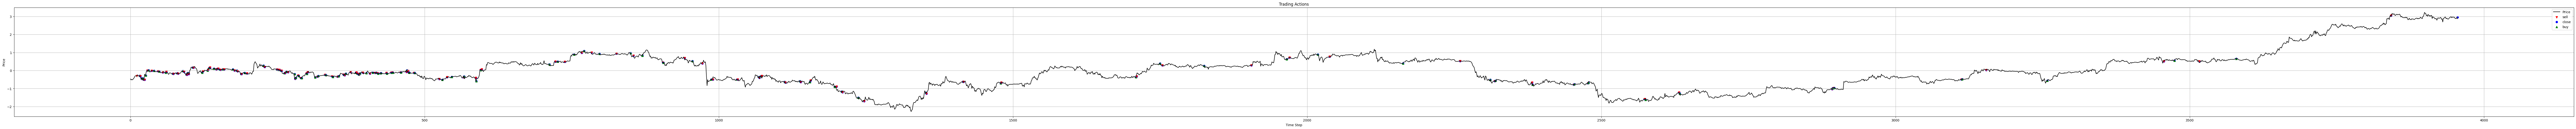

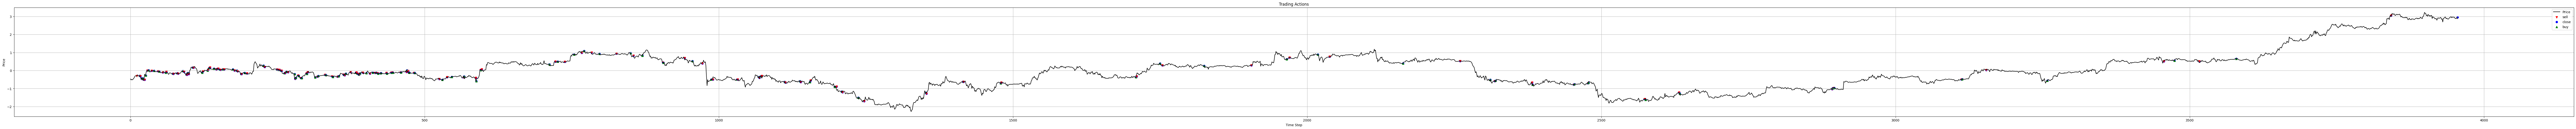

In [54]:
plot_trades(data, total_trades[0])
plot_trades(data, total_trades[episodes-1])


In [16]:
def plot_balance(balances1):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(balances1) + 1), balances1, label='balance', color='blue')
    plt.title('balance')
    plt.xlabel('trades')
    plt.ylabel('value')
    plt.legend()
    plt.grid(True)
    plt.show()

print('ok')

ok


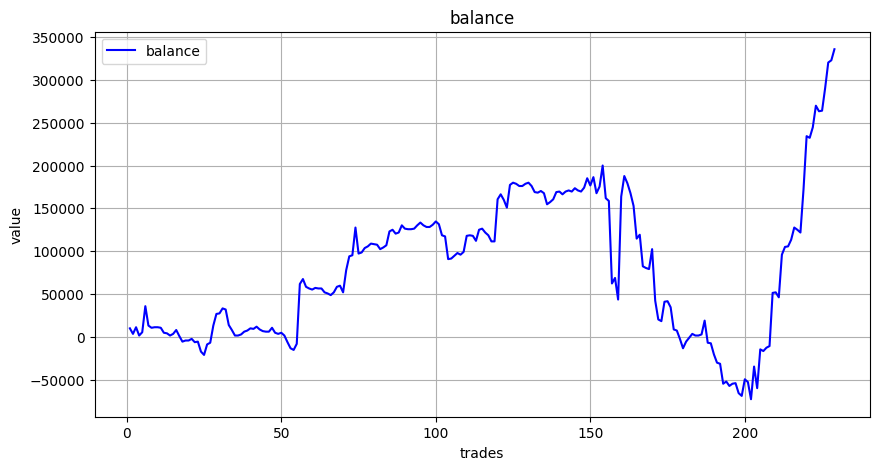

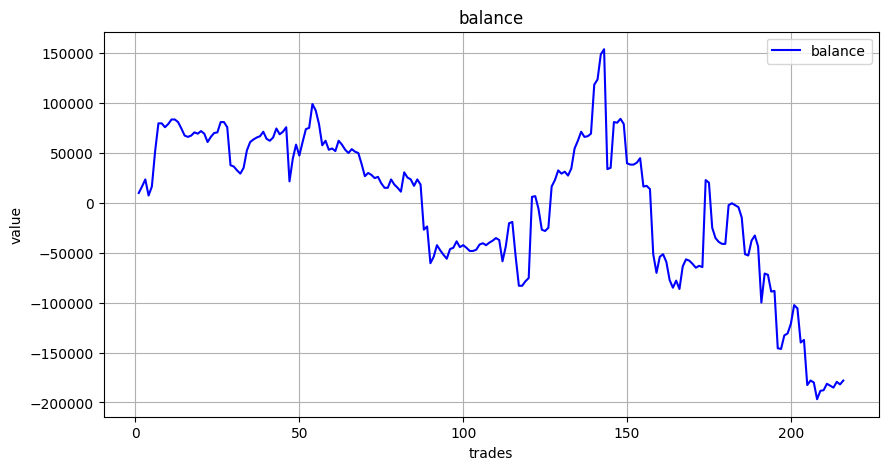

In [21]:
plot_balance(total_balances[0])
plot_balance(total_balances[episodes-1])

In [18]:
def plot_reward(rwd):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(rwd) + 1), rwd, label='rewards', color='red')
    plt.title('rewards')
    plt.xlabel('trades')
    plt.ylabel('value')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_action(rwd):
    plt.figure(figsize=(10, 5))
    plt.bar(range(1, len(rwd) + 1), rwd, label='actions', color='blue')
    plt.title('actions 0-hold, 1 - buy, 2-sell, 3-close')
    plt.xlabel('index')
    plt.ylabel('value')
    plt.legend()
    plt.grid(True)
    plt.show()

print('ok')

ok


D:\progs\python\python3.9.13\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


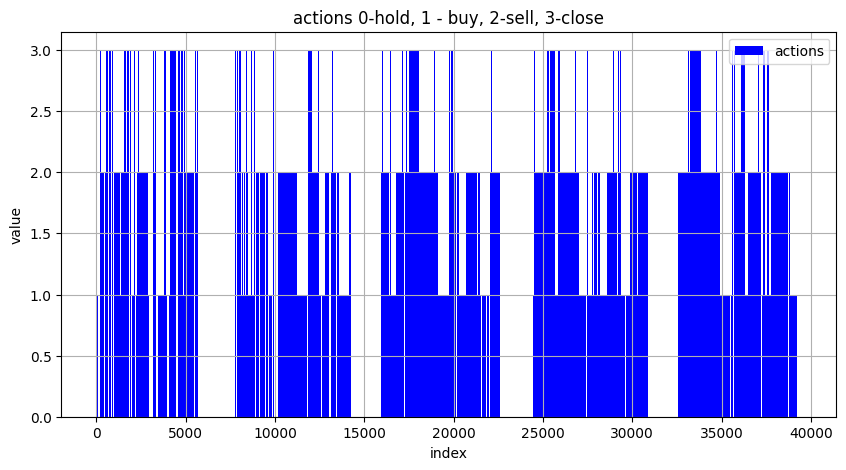

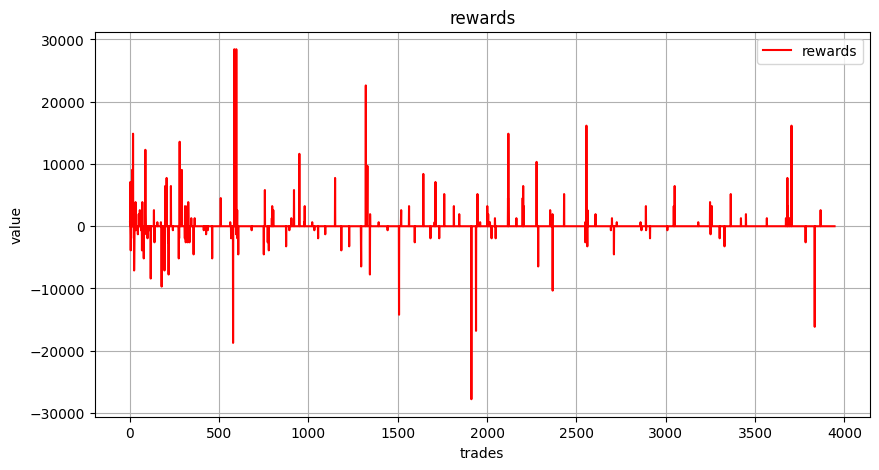

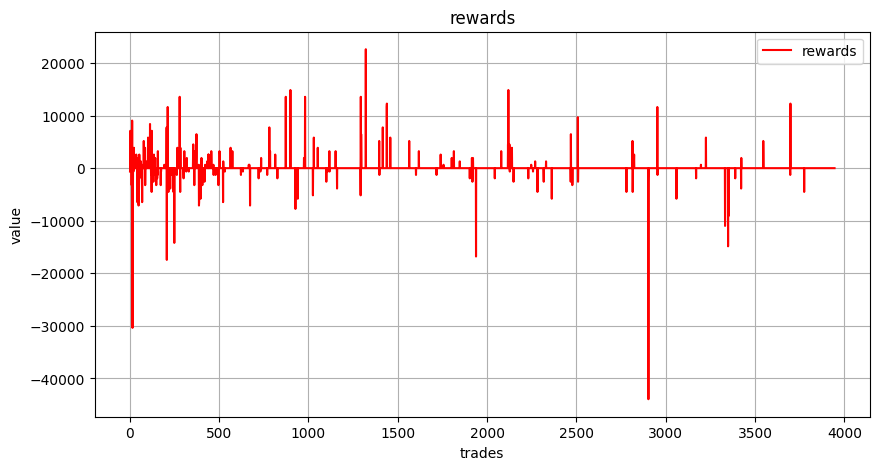

In [19]:
plot_action(total_actions)

plot_reward(total_rewards[0])
plot_reward(total_rewards[episodes-1])


In [ ]:
# test

шаг: 1800, action:0 position_type: None, balance: 10000.00
balance: 10000.00                                                  


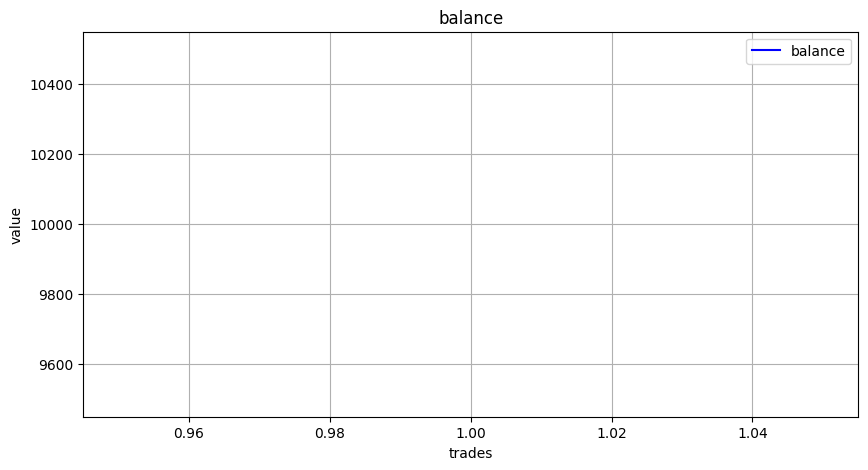

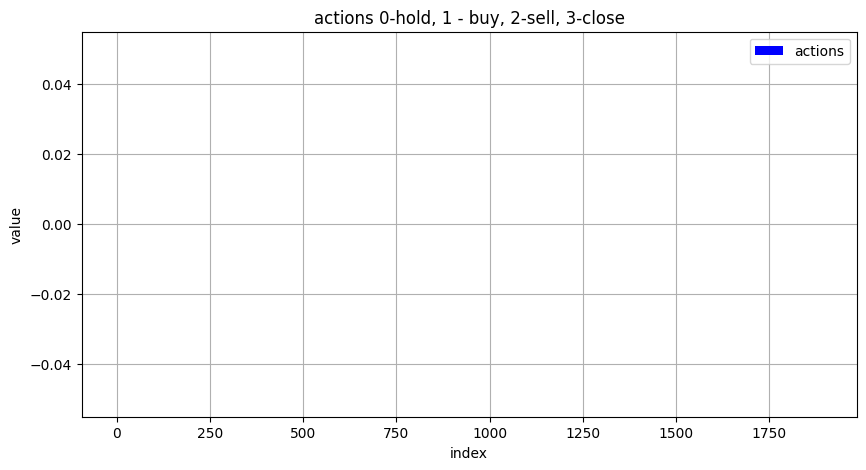

In [23]:

data_test = dataset[(dataset['date'] >= '2008.02.01') & (dataset['date'] < '2008.03.01')]
data_test = pd.DataFrame({'close': data_test['close']})

#scaler = StandardScaler()
data_test['close'] = scaler.transform(data_test[['close']])

env_test = QEnvirontment(data_test, window_size=window_size)

q_network_test = QNetwork(state_size, action_size).to(device)
q_network_test.load_state_dict(q_network.state_dict())

total_actions_test = []

agent_test = QAgent(q_network_test, 0.0)
#agent_test.epsilon = 0.0
#print(agent_test.epsilon)
state = env_test.reset()
done = False
total_reward = 0
while not done:
    q_network_test.eval()
    with torch.no_grad():
        action = agent_test.choose_action(state)
        total_actions_test.append(action)
        next_state, reward, done = env_test.step(action)
    
        if env_test.current_step % 100 == 0:
            print(f"шаг: {env_test.current_step}, action:{action} position_type: {env_test.position_type}, balance: {env_test.balance:.2f}", end = '\r', flush=True)

print()
print(f"balance: {env_test.balance:.2f}                                                  ")
plot_balance(env_test.trade_balance)
plot_action(total_actions_test)